**Load the data from drive**

In [2]:
#Load and print dataframe
import pandas as pd
from google.colab import drive
import tensorflow as tf
import copy as copy

drive.mount('/content/drive')
path = '/content/drive/MyDrive/IE534 itn/Project/Data'
df=pd.read_pickle(path+'/rnn_dataframe.pkl')
#Unemployment= [4]
df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,area_name,labor_force,employment,unemployment,unemployment_rate
0,California,"[9672362, 9684440, 9689626, 9692493, 9712533, ...","[8668016, 8704564, 8776344, 8835232, 8945196, ...","[1004346, 979876, 913282, 857261, 767337, 8924...","[0.104, 0.101, 0.094, 0.088, 0.079, 0.09, 0.09..."
1,Los Angeles County,"[3364151, 3364401, 3361820, 3362757, 3349943, ...","[3040058, 3050306, 3069797, 3082562, 3089152, ...","[324093, 314095, 292023, 280195, 260791, 29694...","[0.096, 0.093, 0.087, 0.083, 0.078, 0.088, 0.0..."
2,Los Angeles-Long Beach-Glendale MD,"[3364151, 3364401, 3361820, 3362757, 3349943, ...","[3040058, 3050306, 3069797, 3082562, 3089152, ...","[324093, 314095, 292023, 280195, 260791, 29694...","[0.096, 0.093, 0.087, 0.083, 0.078, 0.088, 0.0..."
3,Alameda County,"[676500, 673100, 672900, 670500, 671500, 67700...","[650200, 648100, 648700, 645100, 646300, 64990...","[26300, 25000, 24200, 25400, 25200, 27100, 306...","[0.039, 0.037, 0.036, 0.038, 0.037, 0.04, 0.04..."
4,Alpine County,"[600, 640, 620, 470, 270, 250, 220, 220, 230, ...","[580, 620, 600, 450, 220, 210, 190, 200, 180, ...","[20, 20, 20, 20, 50, 40, 40, 20, 50, 50, 50, 6...","[0.025, 0.033, 0.034, 0.051, 0.169, 0.159, 0.1..."


**Extract unemployment rate and total workforce as features**

In [3]:
#lets use the first index which has 561 observation as training
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


x_total=np.asarray([df.iloc[0][4],df.iloc[0][1]])
# decomposed_data=seasonal_decompose(x_total, model='additive',period=1)
# decomposed_data.plot()

**Partition data into train and test and validation**

The first 80% of data is training data, the next 10% of data is validation data and the last 10% of data is test data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


#We use the split twice...
x_total_normalized=scaler.fit_transform(x_total.reshape(-1, 2))
train, test_and_val = train_test_split(x_total_normalized, test_size=0.2, shuffle=False)

validation, test = train_test_split(test_and_val, test_size=0.5, shuffle=False)

print("Train shape: ", train.shape)
print("Validation shape: ", validation.shape)
print("Test shape: ",test.shape)

Train shape:  (448, 2)
Validation shape:  (56, 2)
Test shape:  (57, 2)


**Define number of features and length of look back window and timeseries data generator**

In [5]:
from scipy.signal.windows import general_cosine
from keras.preprocessing.sequence import TimeseriesGenerator

#look_back.We create windows of this length and try to predict the next value
#And we will move the window one by one
#Play with this!
n_input = 6

#if multivariate, it will be more than 1
n_features = 2

generatorTrain = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
generatorTest= TimeseriesGenerator(test, test, length=n_input, batch_size=1)
generatorValidation= TimeseriesGenerator(validation, validation, length=n_input, batch_size=1)

In [6]:
#lets see what is in a single batch window
batch_0 = generatorTrain[0]
x, y= batch_0

print(x,y)

[[[3.50207587e-09 3.21941050e-09]
  [2.99452865e-09 2.55508770e-09]
  [2.23320780e-09 2.65729120e-09]
  [3.04528337e-09 2.70839296e-09]
  [2.69000031e-09 2.55508770e-09]
  [2.94377392e-09 2.65729120e-09]]] [[3.24830226e-09 3.11720699e-09]]


**Build a deep learning model for the dataset. We used LSTM model here**

LSTM networks combat the RNN's vanishing gradients or long-term dependence issue. Gradient vanishing refers to the loss of information in a neural netw
ork as connections recur over a longer period. The model is defined below. Since we have 2 features, we did not stack multiple LSTM layers

In [34]:
#Vanilla LSTM!
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout


#Create the network and define the model

model = Sequential()
#300 is the shape of output
# model.add(LSTM(300, activation='tanh', input_shape=(n_input, n_features)))
model.add(LSTM(300, activation='tanh', input_shape=(n_input, n_features)))
model.add(Dense(1))

**Investigate effects of mini-batch learning**

In this section we use several batch sizes. Sevral powers of two batch_size will be tried and the loss on validation data is analyzed. The same model with same initialization would be trained for the same number of epochs for fair comparision. Based on these experiments the **Optimal batch size is 64** according to dev set. We also used early stopping to retain the best obtained model.

In [8]:
import absl.logging
from tqdm import tqdm

absl.logging.set_verbosity(absl.logging.ERROR)

batch_sizes=[1, 2, 4, 8, 16, 32, 64, 128]
EPOCHS=30

model.compile(optimizer='adam', loss='mse')
callback= tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="auto", baseline=None, restore_best_weights=True,)
validation_loss=[]

for i in tqdm(range(len(batch_sizes))):
  batch_size=batch_sizes[i]
  #clone model for fair comparision. Rather than continuing training, just train the model from scratch
  cloned_model=copy.deepcopy(model)
  cloned_model.fit(generatorTrain, epochs=EPOCHS, batch_size=batch_size, shuffle=False, validation_data=generatorValidation, verbose=0, callbacks=[callback])
  loss=cloned_model.evaluate(generatorValidation)
  validation_loss.append(loss)

  0%|          | 0/8 [00:00<?, ?it/s]

50/50 [==============================] - 0s 3ms/step - loss: 1.1620e-04


 12%|█▎        | 1/8 [00:44<05:13, 44.83s/it]

50/50 [==============================] - 0s 3ms/step - loss: 1.3633e-04


 25%|██▌       | 2/8 [01:30<04:31, 45.23s/it]

50/50 [==============================] - 0s 3ms/step - loss: 1.3617e-04


 38%|███▊      | 3/8 [02:34<04:29, 53.91s/it]

50/50 [==============================] - 0s 3ms/step - loss: 1.0543e-04


 50%|█████     | 4/8 [03:39<03:53, 58.25s/it]

50/50 [==============================] - 0s 3ms/step - loss: 2.5262e-04


 62%|██████▎   | 5/8 [04:23<02:39, 53.15s/it]

50/50 [==============================] - 0s 3ms/step - loss: 2.7056e-04


 75%|███████▌  | 6/8 [05:29<01:55, 57.61s/it]

50/50 [==============================] - 0s 3ms/step - loss: 8.7404e-05


 88%|████████▊ | 7/8 [06:25<00:57, 57.03s/it]

50/50 [==============================] - 0s 3ms/step - loss: 1.3193e-04


100%|██████████| 8/8 [07:15<00:00, 54.39s/it]


Oprimal batch size according to validation data is  64


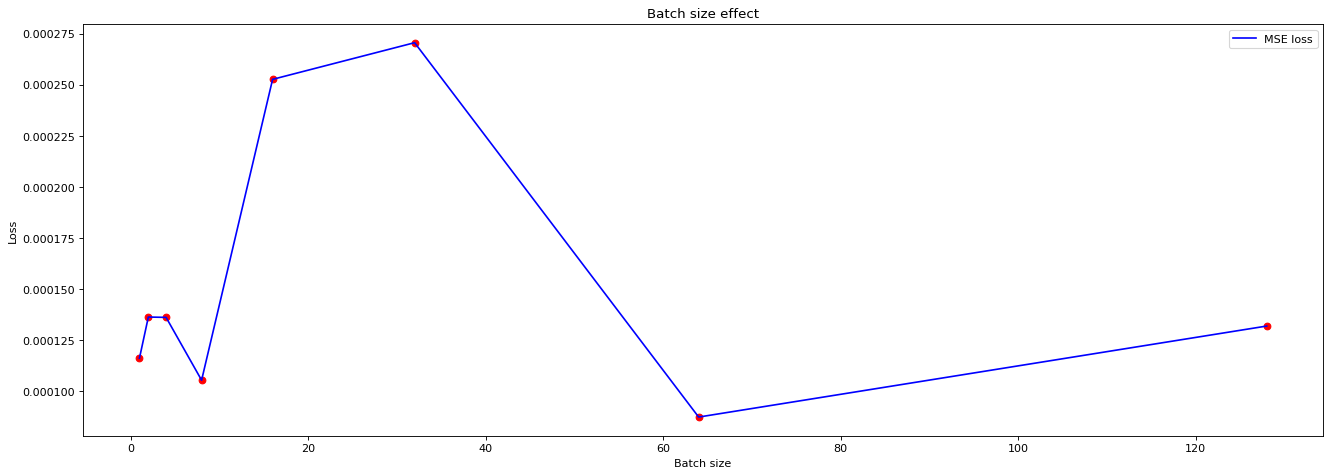

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(20, 15), dpi=80)
plt.subplot(211)
plt.plot(np.asarray(batch_sizes), np.asarray(validation_loss), 'b')
plt.scatter(np.asarray(batch_sizes), np.asarray(validation_loss), c='red')

plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.legend(['MSE loss'], loc='upper right')
plt.title("Batch size effect")

optimal_batch_size= batch_sizes[np.argmin(np.asarray(validation_loss))]

print("Oprimal batch size according to validation data is ", optimal_batch_size)

**Comment on size of minibatch**

When training a model, a batch  of data is a fixed number of training data is fed to the model and the model undergoes one training step which is an update for its parameters with respect to the gradients of the loss of the batch.

There is a myth stating that batch size should be power of 2 since it can be feed into an entire GPU for an efficient and fast training. But it is not the [case](https://wandb.ai/datenzauberai/Batch-Size-Testing/reports/Do-Batch-Sizes-Actually-Need-to-be-Powers-of-2---VmlldzoyMDkwNDQx) and although power of 2 is conventional, it is not the only option.

Large batch sizes boosts the training speed, but will lead to sharp minima and will suffer from low generalization and lower test performance. Moreover, care should be taken than all the samples in the batch fit in the GPU memory, since model is cloned once for each training sample in the batch.

In contrast, smaller bath sizes lead to flatter minima that generalizes bettr to the test set. The phenomena happens since smaller batches are more likely to contain more diverse sample which introduces more sthochasticity into the model that causes better regularization.

Finally, it should be noted that no unique batch size is good and it is totally dependant on the model architecture and the target dataset and it should be tuned on the dev set. It should be noted that the learning rate should also be adjusted for batch size. Bigger batch sizes should be accompanied by bigger learning rate and vice versa, since it is desired to make changes based on the size of observed samples.

**Effect of different optimizers**

Various Keras optimizers are used and their effect is evaluated on the validation set. We used early stopping and retain the best reached model achieved so far during training. Each optimizer is used on a cloned version of a model with equal initilization and for same number of epochs.

In [10]:
optimizers_name= ['RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'SGD']
EPOCHS=30


callback= tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="auto", baseline=None, restore_best_weights=True,)
validation_loss=[]

for i in tqdm(range(len(optimizers_name))):
  optimizer=optimizers_name[i]
  #clone model for fair comparision. Rather than continuing training, just train the model from scratch
  cloned_model=copy.deepcopy(model)
  cloned_model.compile(optimizer=optimizer, loss='mse')
  cloned_model.fit(generatorTrain, epochs=EPOCHS, batch_size=optimal_batch_size, shuffle=False, validation_data=generatorValidation, verbose=0, callbacks=[callback])
  loss=cloned_model.evaluate(generatorValidation)
  validation_loss.append(loss)


  0%|          | 0/8 [00:00<?, ?it/s]

50/50 [==============================] - 0s 3ms/step - loss: 1.1642e-04


 12%|█▎        | 1/8 [00:51<06:01, 51.60s/it]

50/50 [==============================] - 0s 3ms/step - loss: 2.1302e-04


 25%|██▌       | 2/8 [02:02<06:16, 62.69s/it]

50/50 [==============================] - 0s 3ms/step - loss: 0.2455


 38%|███▊      | 3/8 [03:22<05:54, 70.96s/it]

50/50 [==============================] - 0s 3ms/step - loss: 0.0030


 50%|█████     | 4/8 [04:38<04:51, 72.83s/it]

50/50 [==============================] - 0s 3ms/step - loss: 4.2525e-05


 62%|██████▎   | 5/8 [05:37<03:24, 68.00s/it]

50/50 [==============================] - 0s 3ms/step - loss: 8.7915e-05


 75%|███████▌  | 6/8 [06:40<02:12, 66.30s/it]

50/50 [==============================] - 0s 3ms/step - loss: 0.6497


 88%|████████▊ | 7/8 [08:25<01:18, 78.85s/it]

50/50 [==============================] - 0s 3ms/step - loss: 9.8457e-04


100%|██████████| 8/8 [09:59<00:00, 74.90s/it]


In [11]:
for i in range(len(optimizers_name)):
  print("Optimizer ", optimizers_name[i], " achieved validation loss of ", validation_loss[i])

optimal_optimizer= optimizers_name[np.argmin(np.asarray(validation_loss))]

print("Oprimal Optimizer according to validation data is ", optimal_optimizer)


Optimizer  RMSprop  achieved validation loss of  0.00011641762830549851
Optimizer  Adam  achieved validation loss of  0.00021302240202203393
Optimizer  Adadelta  achieved validation loss of  0.2454807609319687
Optimizer  Adagrad  achieved validation loss of  0.003006086451932788
Optimizer  Adamax  achieved validation loss of  4.252516373526305e-05
Optimizer  Nadam  achieved validation loss of  8.791458822088316e-05
Optimizer  Ftrl  achieved validation loss of  0.6497360467910767
Optimizer  SGD  achieved validation loss of  0.0009845702443271875
Oprimal Optimizer according to validation data is  Adamax


****Comment on the effect of optimizer****

Optimizers are the strategies to drive the model to the optimial parameters based on the training data. They can be devided into two general catagoriez: 

1- Gradient decent optimizers which have fixed learning rate. They are either batch, stochastic or mini batch 

2- Adaptive optimizers which do not require learning rate tuning and learning rate is automatically adjusted. They are Adagrad, Adadelta, RMSprop, Adam

A short description from each algorithm is brought from [1](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e), [2](https://machinelearningmastery.com/gradient-descent-optimization-with-adamax-from-scratch/), [3](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/Ftrl#:~:text=%22Follow%20The%20Regularized%20Leader%22%20(,McMahan%20et%20al.%2C%202013.), [4](https://machinelearningmastery.com/gradient-descent-optimization-with-nadam-from-scratch/):

**Adagrad:**
It adapts the learning rate to the parameters performing small updates for frequently occurring features and large updates for the rarest ones.

**Adadelta:**
It improves the previous algorithm by introducing a history window which sets a fixed number of past gradients to take in consideration during the training.

**RMSprop:**
It is very similar to Adadelta. The only difference is in the way they manage the past gradients.

**Adam:**
It adds to the advantages of Adadelta and RMSprop, the storing of an exponentially decaying average of past gradients similar to momentum.

**AdaMax:**
is an extension to the Adam version of gradient descent that generalizes the approach to the infinite norm (max) and may result in a more effective optimization on some problems.

**Nadam:**
 is an extension of the Adam algorithm that incorporates Nesterov momentum and can result in better performance of the optimization algorithm.

 **Ftrl:**  is an optimization algorithm developed at Google for click-through rate prediction in the early 2010s. It is most suitable for shallow models with large and sparse feature spaces.


In general, each optimizer has its own pros and cons. It is better to start with some simple optimizer algorithm like adam and then move to more complex ones if needed. Adam usually works well in practice. For shallow networks SGD and Nadam may be used and for deep networks Adam or RMSprop may be used. [reference](https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/). Based on the above results, we will use adamax for this project.




**Tune hyperparameters (training testing and validation)**

So far we have ivestigated the effect of batch size and optimizer on the dev set and have decided to stick with Adamax optimizer and batch size of 64. Now for further tuning the hyperparameters, given that our neural architecture is already performing well, we keep it fixed and will try different optimizer hyerparameters on the validation set.

Note that we use greed search for serching the hyperparameter space. For each combination, we train a cloned version of model for 30 epochs and record theb est achieved result on validation set and use it for comparison.


In [22]:
learning_rates=[0.001, 0.0001]
beta_1s=[0.9, 0.99]
beta_2s=[0.999, 0.9999]
epsilons=[1e-6, 1e-7]
best_loss_found=10000000
best_hyperparameters_found={}
EPOCHS=20

for learning_rate in learning_rates:
  for beta_1 in beta_1s:
    for beta_2 in beta_2s:
      for epsilon in epsilons:
        optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, name="Adamax")
        cloned_model=copy.deepcopy(model)
        cloned_model.compile(optimizer=optimizer, loss='mse')
        cloned_model.fit(generatorTrain, epochs=EPOCHS, batch_size=optimal_batch_size, shuffle=False, validation_data=generatorValidation, verbose=0, callbacks=[callback])
        loss=cloned_model.evaluate(generatorValidation, verbose=0)

        if loss < best_loss_found:
          best_loss_found=loss
          best_hyperparameters_found['b1']=beta_1
          best_hyperparameters_found['b2']=beta_2
          best_hyperparameters_found['epsilon']=epsilon
          best_hyperparameters_found['learning_rate']=learning_rate
        
        print("Achieved loss of ", loss, " with hyper parameters: ", learning_rate," ", beta_1, " ", beta_2, " ", epsilon)

    

print("best ahieved hyeperparameters are : lr= ", best_hyperparameters_found['learning_rate'], " beta_1= ", best_hyperparameters_found['b1'], ' beta_2= ', best_hyperparameters_found['b2'], " epsilon= ",best_hyperparameters_found['epsilon'])



Achieved loss of  0.002700971672311425  with hyper parameters:  0.001   0.9   0.999   1e-06
Achieved loss of  0.001054560299962759  with hyper parameters:  0.001   0.9   0.999   1e-07
Achieved loss of  0.0015999102033674717  with hyper parameters:  0.001   0.9   0.9999   1e-06
Achieved loss of  0.003022223711013794  with hyper parameters:  0.001   0.9   0.9999   1e-07
Achieved loss of  0.0028842175379395485  with hyper parameters:  0.001   0.99   0.999   1e-06
Achieved loss of  0.003979772794991732  with hyper parameters:  0.001   0.99   0.999   1e-07
Achieved loss of  0.003488096408545971  with hyper parameters:  0.001   0.99   0.9999   1e-06
Achieved loss of  0.004031605552881956  with hyper parameters:  0.001   0.99   0.9999   1e-07
Achieved loss of  0.0053725712932646275  with hyper parameters:  0.0001   0.9   0.999   1e-06
Achieved loss of  0.004588702693581581  with hyper parameters:  0.0001   0.9   0.999   1e-07
Achieved loss of  0.004091124515980482  with hyper parameters:  0.0

In [25]:
learning_rates=[0.001, 0.01]
beta_1s=[0.9, 0.99]
beta_2s=[0.999, 0.9999]
epsilons=[1e-6, 1e-7]
best_loss_found=10000000
best_hyperparameters_found={}
EPOCHS=20

for learning_rate in learning_rates:
  for beta_1 in beta_1s:
    for beta_2 in beta_2s:
      for epsilon in epsilons:
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, name="adam")
        cloned_model=copy.deepcopy(model)
        cloned_model.compile(optimizer=optimizer, loss='mse')
        cloned_model.fit(generatorTrain, epochs=EPOCHS, batch_size=optimal_batch_size, shuffle=False, validation_data=generatorValidation, verbose=1, callbacks=[callback])
        loss=cloned_model.evaluate(generatorValidation, verbose=0)

        if loss < best_loss_found:
          best_loss_found=loss
          best_hyperparameters_found['b1']=beta_1
          best_hyperparameters_found['b2']=beta_2
          best_hyperparameters_found['epsilon']=epsilon
          best_hyperparameters_found['learning_rate']=learning_rate
        
        print("Achieved loss of ", loss, " with hyper parameters: ", learning_rate," ", beta_1, " ", beta_2, " ", epsilon)

    

print("best ahieved hyeperparameters are : lr= ", best_hyperparameters_found['learning_rate'], " beta_1= ", best_hyperparameters_found['b1'], ' beta_2= ', best_hyperparameters_found['b2'], " epsilon= ",best_hyperparameters_found['epsilon'])


Epoch 1/20
442/442 [==============================] - 6s 7ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 2/20
442/442 [==============================] - 3s 6ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 3/20
442/442 [==============================] - 3s 6ms/step - loss: 0.0048 - val_loss: 9.9592e-04
Epoch 4/20
442/442 [==============================] - 2s 6ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 5/20
442/442 [==============================] - 2s 6ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 6/20
442/442 [==============================] - 2s 5ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 7/20
442/442 [==============================] - 2s 6ms/step - loss: 0.0047 - val_loss: 1.8528e-04
Epoch 8/20
442/442 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 0.0062
Epoch 9/20
442/442 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 10/20
442/442 [==============================] - 2s 6ms/step - loss: 0.0047 - val_loss

The above validation loss is quite high. Although we still can extract the best hyperparameters, it is wise to switch to adam and do the hyper parameter tuning again. It can be seen that lower loss values can be obtained with adam.

**Training the final model**

Now that we have a model and have found its optimal hyper-parameters, it is now time to train the original model for many more epochs and evaluate it on the test data.

**Important notice:**

The original dataset consists of nearly 1000 counties of the State of California and the whole state of California itself. First of all, we only used the seasonally adjusted version as it tries to remove the effect of season and let us extract more reliable pattern. 

The second point is that we decided to train a seperate model for each county. That is, we did not consider each area as a feature. There are two justifications for it. First of all, the dataset was incomplete and for a vast majority of counties, we only had unemployment rates from early 90's. Several counties and the whole state had data from early 70's. So, since the data is incomplete it would not make sense to train the model on earlier dates since an accurate extrapolation is impossible. Furthermore, if we only used the latest available date and treated all areas as a feature for now that we have data for all of them, the problem would be that we have discarded a great portion of our data.

The third justification is that each county might have its own unemployment pattern, and merging several counties will not make sense since we are trying to learn one function from multiple functions with different behaviors!


With above in mind, we decided to train a seperate model for each area name. This notebook deals with the State of California, for which the greatest number of data is possible.

A drawback to this approach is that we might be neglecting the effect of nearby counties on the unemployment rate, since people might migrate. But this is not the case. First of all, such a pattern would also be reflected in the total workforce and by considering that as a feature we have addressed the migration issue. And second, as seen from the results, the models are performing quite well on validation set (and at the end of this notebook we will see that it also performs well on test set). So we also have a good model with low test loss so it also verifies our assumptions!

In the next notebook, we will train a seperate model for the reamining area names. What follows will be training of the model for the State of California. For other area names, the same model with the same hyper parameters will be used except that we split data only in train and test partitions and we don't have any validation set as we have already chosen our hyper parameters from the model for State of California.

Epoch 1/300
442/442 [==============================] - 4s 5ms/step - loss: 0.0027 - val_loss: 2.1895e-04
Epoch 2/300
442/442 [==============================] - 2s 4ms/step - loss: 0.0017 - val_loss: 3.2456e-04
Epoch 3/300
442/442 [==============================] - 2s 4ms/step - loss: 0.0032 - val_loss: 3.5601e-04
Epoch 4/300
442/442 [==============================] - 2s 4ms/step - loss: 0.0019 - val_loss: 2.0152e-04
Epoch 5/300
442/442 [==============================] - 2s 4ms/step - loss: 9.2999e-04 - val_loss: 1.4229e-04
Epoch 6/300
442/442 [==============================] - 2s 5ms/step - loss: 9.3111e-04 - val_loss: 8.7614e-05
Epoch 7/300
442/442 [==============================] - 2s 4ms/step - loss: 6.5110e-04 - val_loss: 3.8463e-05
Epoch 8/300
442/442 [==============================] - 2s 5ms/step - loss: 5.5157e-04 - val_loss: 3.5274e-05
Epoch 9/300
442/442 [==============================] - 2s 4ms/step - loss: 4.9982e-04 - val_loss: 3.1125e-05
Epoch 10/300
442/442 [=============

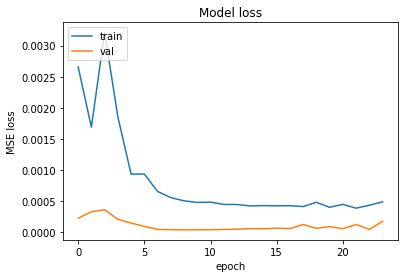

In [40]:
EPOCHS=300
callback= tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0, patience=15, verbose=0, mode="auto", baseline=None, restore_best_weights=True,)
optimizer=tf.keras.optimizers.Adam(learning_rate= best_hyperparameters_found['learning_rate'], beta_1= best_hyperparameters_found['b1'], beta_2=best_hyperparameters_found['b2'], epsilon=best_hyperparameters_found['epsilon'], name="adam")
cloned_model=copy.deepcopy(model)
model.compile(optimizer='adam', loss='mse')
history= model.fit(generatorTrain, epochs=EPOCHS, batch_size=16, shuffle=False, validation_data=generatorValidation, verbose=1, callbacks=[callback])
loss=cloned_model.evaluate(generatorValidation, verbose=0)



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
model.compile(optimizer='adam', loss='mse')
score=model.evaluate(generatorTest)

51/51 [==============================] - 0s 3ms/step - loss: 1.4940e-04


In [ ]:
#Just load the model instead of training from sctarch
import tensorflow as tf
model_link = '/content/drive/MyDrive/IE534 itn/Project/models/timeseries models/first_two_Features.h5'
# model_link = '1UXPLo2YEsCtx7xDwnmoHTI3mpnp010Cq'
# tf.keras.models.save_model(model,model_link)
model=tf.keras.models.load_model(model_link)
#train loss
model.evaluate(generatorTrain)

#test loss
model.evaluate(generatorTest)

51/51 [==============================] - 0s 7ms/step - loss: 1.4846e-04


'Difference is huge, We are overfitting :O '

In [ ]:
#Extrapolate to future

predictions = []
#the very last window of training
first_batch = train[-n_input:]
print("first ",first_batch.shape)
current_batch = first_batch.reshape((1,n_input, n_features))

for i in range (len(test)):
  # get the prediction value for the first batch
  #current_pred = model.predict(current_batch,verbose=0)[0]
  current_pred = model.predict(current_batch,verbose=0)
  print(current_pred.shape,"CP")

  # append the prediction into the array
  predictions.append(current_pred)

  # remove the first value
  current_batch_rmv_first = current_batch[:,1:,:]

  print(current_batch[0].shape)
  print(current_batch_rmv_first[0].shape)
  #update the batch
  current_batch = np.append(current_batch_rmv_first, [[current_pred]],axis=1)


first  (6, 2)
(1, 1) CP
(6, 2)
(5, 2)


ValueError: ignored

In [ ]:
#lets plot the actual test and prediction
import matplotlib.pyplot as plt

predictions_actual_scale = scaler.inverse_transform(predictions)
test_data_actual_scale = scaler.inverse_transform(test)



fig, axs = plt.subplots(figsize=(20, 10))
plt.plot(predictions_actual_scale)
plt.plot(test_data_actual_scale)



plt.legend(["Predictions" , "Actual"])
plt.ylabel("Unemployment rate")
plt.xlabel("Month")



ValueError: ignored